In [16]:
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from gpytorch.distributions import MultitaskMultivariateNormal
from linear_operator.operators import to_linear_operator

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils import make_grid
from configs import N_SIDE

# attach this to paths since we are running from subfolder
subfolder_pre = "../"

# Visualise tiles

This notebook creates all the individual tiles we then use to make plots for the paper in Powerpoint.
All plots are saved into respective folders in `\figures\`. Figures can be downloaded as a folder to then fill shapes with the corresponding pictures.

In [47]:
# Turn off to protext RAM
show_bool = False
# Toggle on here
# show_bool = True

standard_quiver_scale = 47
standard_quiver_width = 0.0035
# NOTE: branching has smaller magnitude so we need to scale it up: scale is defined inverse
branching_quiver_scale = 22
deflection_quiver_scale = 35
edge_quiver_scale = 37

lim_margin = 0.0526 / 2

## Defining custom colorscale for errors

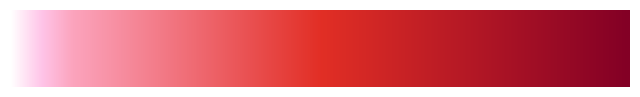

In [3]:
# pink with high sensitivity
values = np.array([0., 0.05, 0.1, 0.5, 1.])
colors = ["white", "#ffc4e8", "#fca4bd", "#e22f26", "#830025"]
error_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(name = "error_cmap", colors = list(zip(values, colors)))

gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack([gradient] * 20)  # Make it tall enough to see

# Plot the gradient with the custom colormap
plt.figure(figsize = (8, 1))
plt.imshow(gradient, aspect = 'auto', cmap = error_cmap)
plt.axis('off')

plt.savefig(f"cmaps/error.png", dpi = 100, bbox_inches = 'tight', pad_inches = 0)

plt.show()

In [4]:
# Import all simulation functions
from simulate import (
    simulate_detailed_branching,
    # simulate_detailed_convergence,
    simulate_detailed_curve,
    simulate_detailed_deflection,
    simulate_detailed_edge,
    simulate_detailed_ridges,
)

# Define simulations as a dictionary with names as keys to function objects
# alphabectic order here
simulations = {
    "branching": simulate_detailed_branching,
    "curve": simulate_detailed_curve,
    "deflection": simulate_detailed_deflection,
    "edge": simulate_detailed_edge,
    "ridges": simulate_detailed_ridges,
}

#############
### TRAIN ###
#############

x_train = torch.load(subfolder_pre + "data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = False).float()

# Storage dictionaries
y_train_dict = {}

# Make y_train_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    # Generate training observations with sim_func
    y_train = sim_func(x_train)
    # Store training data in dictionary under sim_name
    y_train_dict[sim_name] = y_train 

############
### TEST ###
############

# Make x_grid
_, x_test = make_grid(n_side = N_SIDE)

# Storage dictionaries
y_test_dict = {}

# Make y_test_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    # Generate test observations
    y_test = sim_func(x_test)
    y_test_dict[sim_name] = y_test  # Store test outputs

# Ground truth

In [5]:
x_test = x_test.detach()

for (sim_name, y_train) in y_train_dict.items():

    y_test = y_test_dict[sim_name]

    fig, ax = plt.subplots(1, 1, figsize = (5, 5))

    quiver_scale = standard_quiver_scale
    if sim_name == "branching":
        quiver_scale = branching_quiver_scale
    if sim_name == "deflection":
        quiver_scale = deflection_quiver_scale
    if sim_name == "edge":
        quiver_scale = edge_quiver_scale
    
    # Plot ground truth test data in black
    ax.quiver(x_test[:, 0], x_test[:, 1], y_test[:, 0], y_test[:, 1], 
              width = standard_quiver_width, scale = quiver_scale, color = "black")

    # NOTE: WITH LIMS
    ax.set_xlim(0 - lim_margin, 1 + lim_margin)
    ax.set_ylim(0 - lim_margin, 1 + lim_margin)

    # Remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_aspect("equal")

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.savefig(f"ground_truth/{sim_name}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

    if show_bool:
        plt.show()
    plt.close()

# Ground truth + train lines

In [6]:
# Read line segements as pd.DataFrame
line_segments = pd.read_csv(subfolder_pre + "data/sim_data/x_train_lines_start_end_0to1.csv")

# Convert line segments to torch tensor, ignoring the column headers
line_segments = torch.tensor(line_segments.values)

x_train = x_train.detach()
x_test = x_test.detach()

# Define colors
train_line_color = "#3377ff"  # Color for tranparent line to indicate training data
test_color = "black"  # Black for test data

for (sim_name, y_train) in y_train_dict.items():

    # Extract training and test vectors
    y_test = y_test_dict[sim_name]

    fig, ax = plt.subplots(1, 1, figsize = (5, 5))
    
    # Iterate over (9) segements:
    for i in range(0, line_segments.shape[0]):
        ax.plot(
            [line_segments[i, 0], line_segments[i, 1]], # (x_start, x_end)
            [line_segments[i, 2], line_segments[i, 3]], # (y_start, y_end)
            color = train_line_color, alpha = 0.2, linewidth = 4)
        
    quiver_scale = standard_quiver_scale
    if sim_name == "branching":
        quiver_scale = branching_quiver_scale
    if sim_name == "deflection":
        quiver_scale = deflection_quiver_scale
    if sim_name == "edge":
        quiver_scale = edge_quiver_scale
    
    # Plot ground truth test data in black
    ax.quiver(x_test[:, 0], x_test[:, 1], y_test[:, 0], y_test[:, 1], 
              color = test_color, label = "test", width = standard_quiver_width, scale = quiver_scale)

    # NOTE: WITH LIMS
    ax.set_xlim(0 - lim_margin, 1 + lim_margin)
    ax.set_ylim(0 - lim_margin, 1 + lim_margin)

    # Remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_aspect("equal")

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.savefig(f"ground_truth_and_train_lines/{sim_name}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

    if show_bool:
        plt.show()
    plt.close()

# Training vectors

In [7]:
# Read line segements as pd.DataFrame
line_segments = pd.read_csv(subfolder_pre + "data/sim_data/x_train_lines_start_end_0to1.csv")

# Convert line segments to torch tensor, ignoring the column headers
line_segments = torch.tensor(line_segments.values)

x_train = x_train.detach()

# Define colors
train_line_color = "#3377ff"  # Color for tranparent line to indicate training data
test_color = "black"  # Black for test data

for (sim_name, y_train) in y_train_dict.items():

    # Extract training and test vectors
    y_train = y_train_dict[sim_name]

    fig, ax = plt.subplots(1, 1, figsize = (5, 5))

    quiver_scale = standard_quiver_scale
    if sim_name == "branching":
        quiver_scale = branching_quiver_scale
    if sim_name == "deflection":
        quiver_scale = deflection_quiver_scale
    if sim_name == "edge":
        quiver_scale = edge_quiver_scale
    
    # Plot ground truth test data in black
    ax.quiver(x_train[:, 0], x_train[:, 1], y_train[:, 0], y_train[:, 1], 
              color = test_color, label = "test", width = standard_quiver_width, scale = quiver_scale)

    # NOTE: WITH LIMS
    ax.set_xlim(0 - lim_margin, 1 + lim_margin)
    ax.set_ylim(0 - lim_margin, 1 + lim_margin)

    # Remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_aspect("equal")

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.savefig(f"train_lines/{sim_name}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

    if show_bool:
        plt.show()
    plt.close()

# Errors

Plot and save

In [8]:
# 5 sims x 5 models = 25
for sim_name, sim_func in simulations.items():

    # Extract gt
    y_test = y_test_dict[sim_name].detach().cpu()  # shape: (N_SIDE^2, 2)

    X = x_test[:, 0].reshape(N_SIDE, N_SIDE).detach()
    Y = x_test[:, 1].reshape(N_SIDE, N_SIDE).detach()

    for model_name in ["dfNN", "dfGP", "dfNGP", "PINN", "GP"]:
        if model_name in ["dfGP", "dfNGP", "GP"]:
            path = subfolder_pre + "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_mean_predictions.pt"
        else:
            path = subfolder_pre + "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_predictions.pt"

        pred = torch.load(path, weights_only = False).detach().cpu()
        error = torch.abs(pred - y_test) # shape: (N_SIDE^2, 2)
        
        # error over both dims for background color
        error_magnitude = error.sum(dim = -1).reshape(N_SIDE, N_SIDE)

        U = error[:, 0].reshape(N_SIDE, N_SIDE)  # x-component
        V = error[:, 1].reshape(N_SIDE, N_SIDE)  # y-component

        # Plot
        plt.figure(figsize = (5, 5))
        pc = plt.pcolor(X, Y, error_magnitude.detach().numpy(), cmap = error_cmap, shading = "auto", vmax = 3.0) # fixed vmax for consistency
        plt.quiver(X, Y, U, V, scale = 20, color = "black") # fixed scale for consistency
        # plt.colorbar(pc, label = "Error magnitude")
        # plt.title("Error Field with Quiver Overlay")

        plt.gca().set_aspect('equal')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

        plt.savefig(f"errors/{sim_name}_{model_name}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

        if show_bool:
            plt.show()

        plt.close()

# Predictions

In [9]:
# 5 sims x 5 models = 25
for sim_name, sim_func in simulations.items():

    # Extract gt
    y_test = y_test_dict[sim_name].detach().cpu()  # shape: (N_SIDE^2, 2)

    X = x_test[:, 0].reshape(N_SIDE, N_SIDE).detach()
    Y = x_test[:, 1].reshape(N_SIDE, N_SIDE).detach()

    for model_name in ["dfNN", "dfGP", "dfNGP", "PINN", "GP"]:
        if model_name in ["dfGP", "dfNGP", "GP"]:
            path = subfolder_pre + "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_mean_predictions.pt"
        else:
            path = subfolder_pre + "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_predictions.pt"

        pred = torch.load(path, weights_only = False).detach().cpu()

        U = pred[:, 0].reshape(N_SIDE, N_SIDE)  # x-component
        V = pred[:, 1].reshape(N_SIDE, N_SIDE)  # y-component

        # Plot
        plt.figure(figsize = (5, 5))

        quiver_scale = standard_quiver_scale
        if sim_name == "branching":
            quiver_scale = branching_quiver_scale
        if sim_name == "deflection":
            quiver_scale = deflection_quiver_scale
        if sim_name == "edge":
            quiver_scale = edge_quiver_scale

        plt.quiver(X, Y, U, V, 
                   width = standard_quiver_width, scale = quiver_scale, color = "black") # fixed scale for consistency

        plt.gca().set_aspect('equal')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

         # NOTE: WITH LIMS
        # NOTE: WITH LIMS
        ax.set_xlim(0 - lim_margin, 1 + lim_margin)
        ax.set_ylim(0 - lim_margin, 1 + lim_margin)

        plt.savefig(f"predictions/{sim_name}_{model_name}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

        if show_bool:
            plt.show()
        plt.close()

# Predictions with errors

In [10]:
# 5 sims x 5 models = 25
for sim_name, sim_func in simulations.items():

    # Extract gt
    y_test = y_test_dict[sim_name].detach().cpu()  # shape: (N_SIDE^2, 2)

    X = x_test[:, 0].reshape(N_SIDE, N_SIDE).detach()
    Y = x_test[:, 1].reshape(N_SIDE, N_SIDE).detach()

    for model_name in ["dfNN", "dfGP", "dfNGP", "PINN", "GP"]:
        if model_name in ["dfGP", "dfNGP", "GP"]:
            path = subfolder_pre + "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_mean_predictions.pt"
        else:
            path = subfolder_pre + "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_predictions.pt"

        pred = torch.load(path, weights_only = False).detach().cpu()
        error = torch.abs(pred - y_test) # shape: (N_SIDE^2, 2)
        
        # error over both dims for background color
        error_magnitude = error.sum(dim = -1).reshape(N_SIDE, N_SIDE)

        # quivers are preds now
        U = pred[:, 0].reshape(N_SIDE, N_SIDE)  # x-component
        V = pred[:, 1].reshape(N_SIDE, N_SIDE)  # y-component

        # Plot
        plt.figure(figsize = (5, 5))
        pc = plt.pcolor(X, Y, error_magnitude.detach().numpy(), cmap = error_cmap, shading = "auto", vmax = 3.0) # fixed vmax for consistency
        quiver_scale = standard_quiver_scale
        if sim_name == "branching":
            quiver_scale = branching_quiver_scale

        plt.quiver(X, Y, U, V, scale = quiver_scale, color = "black") # fixed scale for consistency
        # plt.colorbar(pc, label = "Error magnitude")
        # plt.title("Error Field with Quiver Overlay")

        plt.gca().set_aspect('equal')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

        # NOTE: WITH LIMS
        plt.xlim(0 - lim_margin, 1 + lim_margin)
        plt.ylim(0 - lim_margin, 1 + lim_margin)

        plt.savefig(f"predictions_with_errors/{sim_name}_{model_name}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

        if show_bool:
            plt.show()
        plt.close()

# Divergence

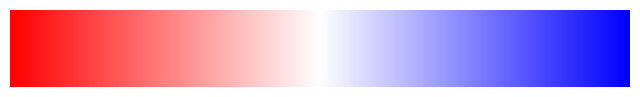

In [11]:
values = np.array([0.0, 0.5, 1.])
colors = ["red", "white", "blue"]
div_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(name = "red_white_blue", colors = list(zip(values, colors)))

gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient = np.vstack([gradient] * 20)  # Make it tall enough to see

# Plot the gradient with the custom colormap
plt.figure(figsize = (8, 1))
plt.imshow(gradient, aspect = 'auto', cmap = div_cmap)
plt.axis('off')

plt.savefig(f"cmaps/divergence.png", dpi = 100, bbox_inches = 'tight', pad_inches = 0)

plt.show()

In [12]:
# 5 sims x 5 models = 25
for sim_name, sim_func in simulations.items():

    # Extract gt
    y_test = y_test_dict[sim_name].detach().cpu()  # shape: (N_SIDE^2, 2)

    X = x_test[:, 0].reshape(N_SIDE, N_SIDE).detach()
    Y = x_test[:, 1].reshape(N_SIDE, N_SIDE).detach()

    for model_name in ["GP", "PINN", "dfGP", "dfNN", "dfNGP"]: 
        path = subfolder_pre + "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_prediction_divergence_field.pt"

        div = torch.load(path, weights_only = False).detach().cpu().reshape(N_SIDE, N_SIDE)

        # Plot
        plt.figure(figsize = (5, 5))
        mag = 3.0 # lower so that PINN divergence is more visible
        plt.pcolormesh(div, cmap = div_cmap, vmin = - mag, vmax = mag) # fixed scale for consistency

        plt.gca().set_aspect('equal')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

        plt.savefig(f"divergence/{sim_name}_{model_name}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

        if show_bool:
            plt.show()
        plt.close()

# Samples (+ error, + uncertainty)

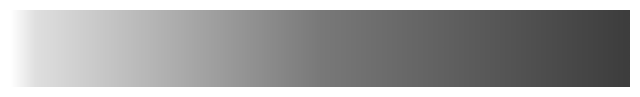

In [48]:
# Make var_cmap 
values = np.array([0.0, 0.04, 0.5, 1.0])
colors = ["white", "#dfdfdf", "#797979", "#3d3d3d"]
var_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(name = "var_cmap", colors = list(zip(values, colors)))

# Plot the gradient with the custom colormap
plt.figure(figsize = (8, 1))
plt.imshow(gradient, aspect = 'auto', cmap = var_cmap)
plt.axis('off')
plt.savefig(f"cmaps/variance.png", dpi = 100, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [49]:
# 5 sims x 4 models = 20
for sim_name, sim_func in simulations.items():

    # Extract gt
    y_test = y_test_dict[sim_name].detach().cpu()  # shape: (N_SIDE^2, 2)

    X = x_test[:, 0].reshape(N_SIDE, N_SIDE).detach()
    Y = x_test[:, 1].reshape(N_SIDE, N_SIDE).detach()

    for model_name in ["GP", "dfGP", "dfGPcm", "dfNGP"]:
        mean_path = subfolder_pre + "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_mean_predictions.pt"
        covar_path = subfolder_pre + "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_covar_predictions.pt"

        mean = torch.load(mean_path, weights_only = False).detach().cpu()
        covar = torch.load(covar_path, weights_only = False).detach().cpu()

        # Access gpytorch dist
        distribution = MultitaskMultivariateNormal(
             mean, to_linear_operator(covar))
        
        n_samples = 3

        ### Uncertainty ###
        # 20 x 20
        # NOTE: Interleaved structure
        var = torch.diag(covar)[0::2].reshape(N_SIDE, N_SIDE) + torch.diag(covar)[1::2].reshape(N_SIDE, N_SIDE)

        ##################
        ### 1. Samples ###
        ##################
        for i in range(n_samples):
            sample = distribution.rsample()

            U = sample[:, 0]
            V = sample[:, 1]

            plt.figure(figsize = (5, 5))

            ### Plot samples ###
            quiver_scale = standard_quiver_scale
            if sim_name == "branching":
                quiver_scale = branching_quiver_scale
            if sim_name == "deflection":
                quiver_scale = deflection_quiver_scale
            if sim_name == "edge":
                quiver_scale = edge_quiver_scale
                
            plt.quiver(X, Y, U, V, 
                       scale = quiver_scale, width = standard_quiver_width, color = "black") 
            # fixed scale for consistency
            
            plt.gca().set_aspect('equal')
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])

            # NOTE: WITH LIMS
            plt.xlim(0 - lim_margin, 1 + lim_margin)
            plt.ylim(0 - lim_margin, 1 + lim_margin)

            plt.savefig(f"samples/{sim_name}_{model_name}_sample_{i}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

            if show_bool:
                plt.show()
            plt.close()

            ##########################
            ### 2. Samples + error ###
            ##########################
            error = torch.abs(sample - y_test)
        
            # error over both dims for background color
            error_magnitude = error.sum(dim = -1).reshape(N_SIDE, N_SIDE)

            plt.figure(figsize = (5, 5))

            plt.pcolor(X, Y, error_magnitude, cmap = error_cmap, shading = "auto", vmax = 3.0)
            # NOTE: quiver scale already selected in loop above
            plt.quiver(X, Y, U, V, scale = quiver_scale, width = standard_quiver_width, color = "black") # fixed scale for consistency

            plt.gca().set_aspect('equal')
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])

            # NOTE: WITH LIMS
            plt.xlim(0 - lim_margin, 1 + lim_margin)
            plt.ylim(0 - lim_margin, 1 + lim_margin)

            plt.savefig(f"samples_with_error/{sim_name}_{model_name}_sample_{i}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

            if show_bool:
                plt.show()
            plt.close()

            ################################
            ### 3. Samples + uncertainty ###
            ################################

            plt.figure(figsize = (5, 5))

            mag = 0.2 # increase so it does not saturate

            # Var extracted above
            plt.pcolormesh(X, Y, var, cmap = var_cmap, vmax = mag, vmin = 0)
            plt.quiver(X, Y, U, V, scale = quiver_scale, width = standard_quiver_width, color = "black") # fixed scale for consistency

            plt.gca().set_aspect('equal')
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])

            # NOTE: WITH LIMS
            plt.xlim(0 - lim_margin, 1 + lim_margin)
            plt.ylim(0 - lim_margin, 1 + lim_margin)

            plt.savefig(f"samples_with_uncertainty/{sim_name}_{model_name}_sample_{i}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)

            if show_bool:
                plt.show()
            plt.close()

# Variance (i.e. uncertainty)

In [50]:
# 5 sims x 4 models = 20
for sim_name, sim_func in simulations.items():

    # Extract gt
    y_test = y_test_dict[sim_name].detach().cpu()  # shape: (N_SIDE^2, 2)

    X = x_test[:, 0].reshape(N_SIDE, N_SIDE).detach()
    Y = x_test[:, 1].reshape(N_SIDE, N_SIDE).detach()

    for model_name in ["GP", "dfGP", "dfGPcm", "dfNGP"]:
        mean_path = subfolder_pre + "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_mean_predictions.pt"
        covar_path = subfolder_pre + "results_sim/" + model_name + "/" + sim_name + "_" + model_name + "_test_covar_predictions.pt"

        mean = torch.load(mean_path, weights_only = False).detach().cpu()
        covar = torch.load(covar_path, weights_only = False).detach().cpu()

        # Access gpytorch dist
        distribution = MultitaskMultivariateNormal(
             mean, to_linear_operator(covar))
        
        n_samples = 3

        # Select every second element starting at index 0 or 1 
        # NOTE: Interleaved structure
        var = torch.diag(covar)[0::2].reshape(N_SIDE, N_SIDE) + torch.diag(covar)[1::2].reshape(N_SIDE, N_SIDE)
        
        plt.figure(figsize = (5, 5))
        mag = 0.2 # increase so it does not saturate
        plt.pcolormesh(var, cmap = var_cmap, vmax = mag, vmin = 0) # fixed scale for consistency, cmap = var_cmap

        plt.gca().set_aspect('equal')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

        plt.savefig(f"variance/{sim_name}_{model_name}.png", dpi = 300, bbox_inches = 'tight', pad_inches = 0)
        print(model_name)
        if show_bool:
            plt.show()
        plt.close()

GP
dfGP
dfGPcm
dfNGP
GP
dfGP
dfGPcm
dfNGP
GP
dfGP
dfGPcm
dfNGP
GP
dfGP
dfGPcm
dfNGP
GP
dfGP
dfGPcm
dfNGP
